# Check the Extracted  Throughput


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation : October 7th 2020 : update with titles


In [38]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [39]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [40]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [41]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import logging
import coloredlogs

import coloredlogs
import configparser
import argparse


In [42]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

# Initialisation

In [44]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [45]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-07 18:38:56,495 MacBook-Pro-de-admin.local __main__[78298] INFO LA time:09:38:56
2020-10-07 18:38:56,496 MacBook-Pro-de-admin.local __main__[78298] INFO NY time:12:38:56
2020-10-07 18:38:56,498 MacBook-Pro-de-admin.local __main__[78298] INFO London time:17:38:56
2020-10-07 18:38:56,499 MacBook-Pro-de-admin.local __main__[78298] INFO Paris time:18:38:56
2020-10-07 18:38:56,500 MacBook-Pro-de-admin.local __main__[78298] INFO ************************ START *********************


In [46]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [47]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-07 18:38:56,515 MacBook-Pro-de-admin.local __main__[78298] INFO Configuration file : config/default.ini


# Configuration

In [48]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-10-07 18:38:56,522 MacBook-Pro-de-admin.local __main__[78298] INFO 1) Configuration


In [49]:
config_section = config.sections()

In [50]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [51]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    holodatadir      =  config['GENERAL']['holodatadir']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [52]:
msg=f" Object observed {target}"
logger.info(msg)

2020-10-07 18:38:56,548 MacBook-Pro-de-admin.local __main__[78298] INFO  Object observed HD116405


In [53]:
# SELECT THE INPUT FILE
inputfilename = outputfile_linearfit
#inputfilename = outputfile_gp

# SED

In [54]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))
s0.convert('flam')

In [55]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [56]:
sed_m=-2.5*np.log10(sed_f)

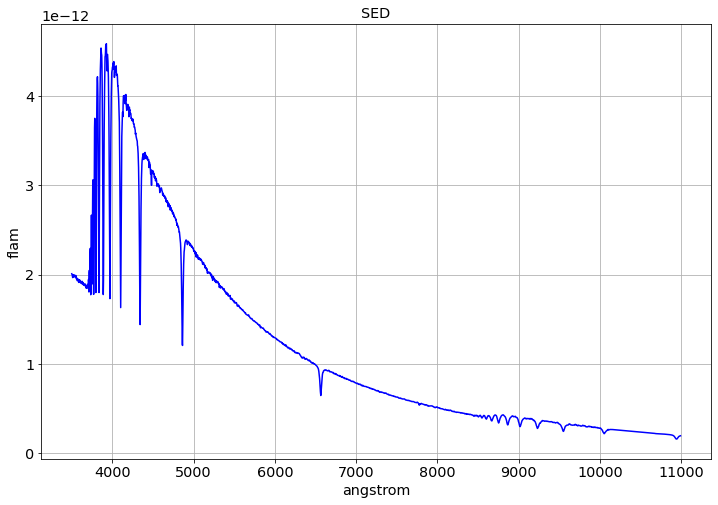

In [57]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(sed_w*10,sed_f/10,"b-")
ax.set_xlabel(s0.waveunits.name)
ax.set_ylabel(s0.fluxunits.name)
ax.set_title("SED")
ax.grid()

## Throughput and eff ratio

In [58]:
file_throuput_effratio="pdm_extracted_throuput_and_o2o1ratio.csv"

In [59]:
df_thr=pd.read_csv(file_throuput_effratio,index_col=0)

In [60]:
df_thr

,wl,throughput,effratio
0,385.000000,0.069184,0.178649
1,391.111111,0.083379,0.174997
2,397.222222,0.096944,0.173716
3,403.333333,0.109889,0.168024
4,409.444444,0.122225,0.157258
...,...,...,...
95,965.555556,0.025930,0.000000
96,971.666667,0.026114,0.000000
97,977.777778,0.026644,0.000000
98,983.888889,0.027528,0.000000


In [61]:
wl_thr=df_thr["wl"].values
through=df_thr["throughput"].values
effratio=df_thr["effratio"].values

## Get spectrum above the atmosphere
The file has been generated by **MLfit_bouguer_linearfit.ipynb** or **MLfit_bouguer_gp.ipynb**     

In [62]:
df=pd.read_csv(inputfilename,index_col=0)

In [63]:
# decode the data
Y0=df["throu"]
EY0=df["errthrou"]
wl0=df["wavelength"]

#### Spectrum above the atmosphere

In [64]:
Y1=df["sedtoa"]
EY1=df["errsedtoa"]
wl1=df["wavelength"]

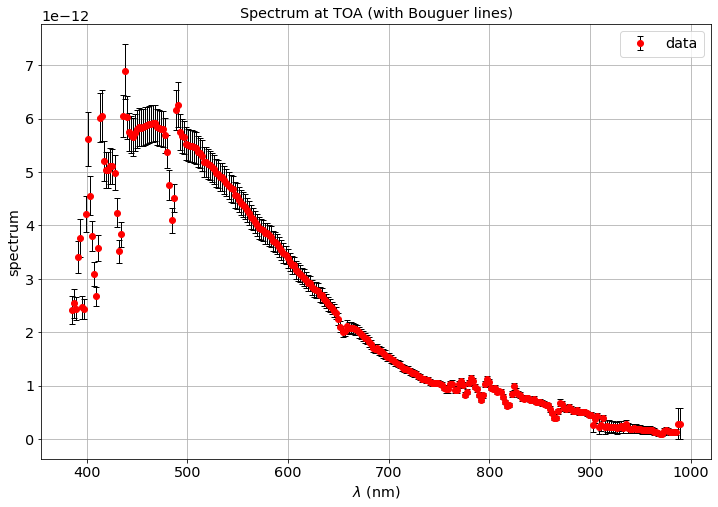

In [65]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log")

## try to extract the second order component from the shifted spline

### Make observation throuth the throughput splined

In [66]:
bp_order1 = S.ArrayBandpass(wl_thr*10, through, name='throughput_o1')
bp_order2 = S.ArrayBandpass(wl_thr*10, through*effratio, name='throughput_o2')

In [67]:
obs1 = S.Observation(s0, bp_order1, force='taper')  # order 1
obs2 = S.Observation(s0, bp_order2, force='taper')  # order 2

(throughput_o1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(throughput_o2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


(300.0, 1000.0)

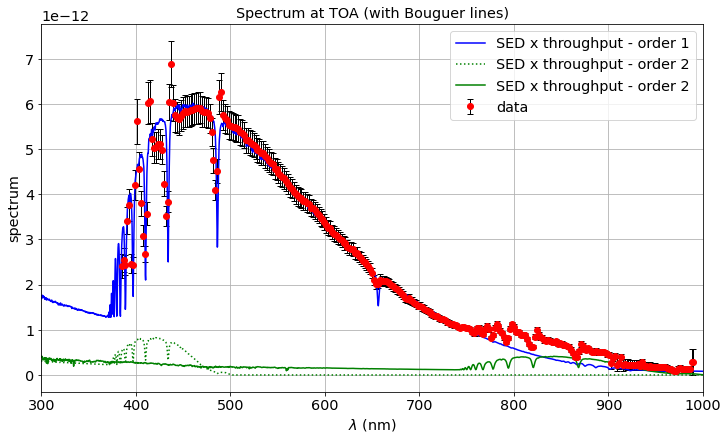

In [75]:
fig=plt.figure(figsize=(10,6),constrained_layout=True)


widths = [1,1]
heights = [1]

spec = fig.add_gridspec(ncols=1, nrows=1, height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])


# top panel
ax1.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")

ax1.plot(obs1.binwave/10, obs1.binflux*10,"b-",label="SED x throughput - order 1")
ax1.plot(obs2.binwave/10, obs2.binflux*10,"g:",label="SED x throughput - order 2")
ax1.plot(2*obs2.binwave/10, obs2.binflux*10/2,"g-",label="SED x throughput - order 2")
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax1.set_title(title)
ax1.legend()
ax1.grid()
ax1.set_xlim(300,1000)
#ax.set_yscale("log")
